In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile,os,random,shutil

In [80]:
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')

In [89]:
df4 = pd.read_csv("MLTempDataset1.csv")
print(df4)

      Unnamed: 0             Datetime  Hourly_Temp
0              0  2022-01-04 00:00:00       20.867
1              1  2022-01-04 01:00:00       21.000
2              2  2022-01-04 02:00:00       20.867
3              3  2022-01-04 03:00:00       20.650
4              4  2022-01-04 04:00:00       20.400
...          ...                  ...          ...
7051        7051  2022-10-24 19:00:00       25.567
7052        7052  2022-10-24 20:00:00       25.183
7053        7053  2022-10-24 21:00:00       24.600
7054        7054  2022-10-24 22:00:00       23.986
7055        7055  2022-10-24 23:00:00       23.383

[7056 rows x 3 columns]


Dataset diambil dari [kaggle](https://www.kaggle.com/datasets/vitthalmadane/ts-temp-1?select=MLTempDataset1.csv)

Dimana dataset diambil pada rentang waktu 4 Januari 2022 hingga 25 Oktober 2022 dan data diambil tiap jam dan temperatur ruangan di rata-rata (Hourly_Temp)

In [137]:
df4.isnull().sum()

Unnamed: 0     0
Datetime       0
Hourly_Temp    0
dtype: int64

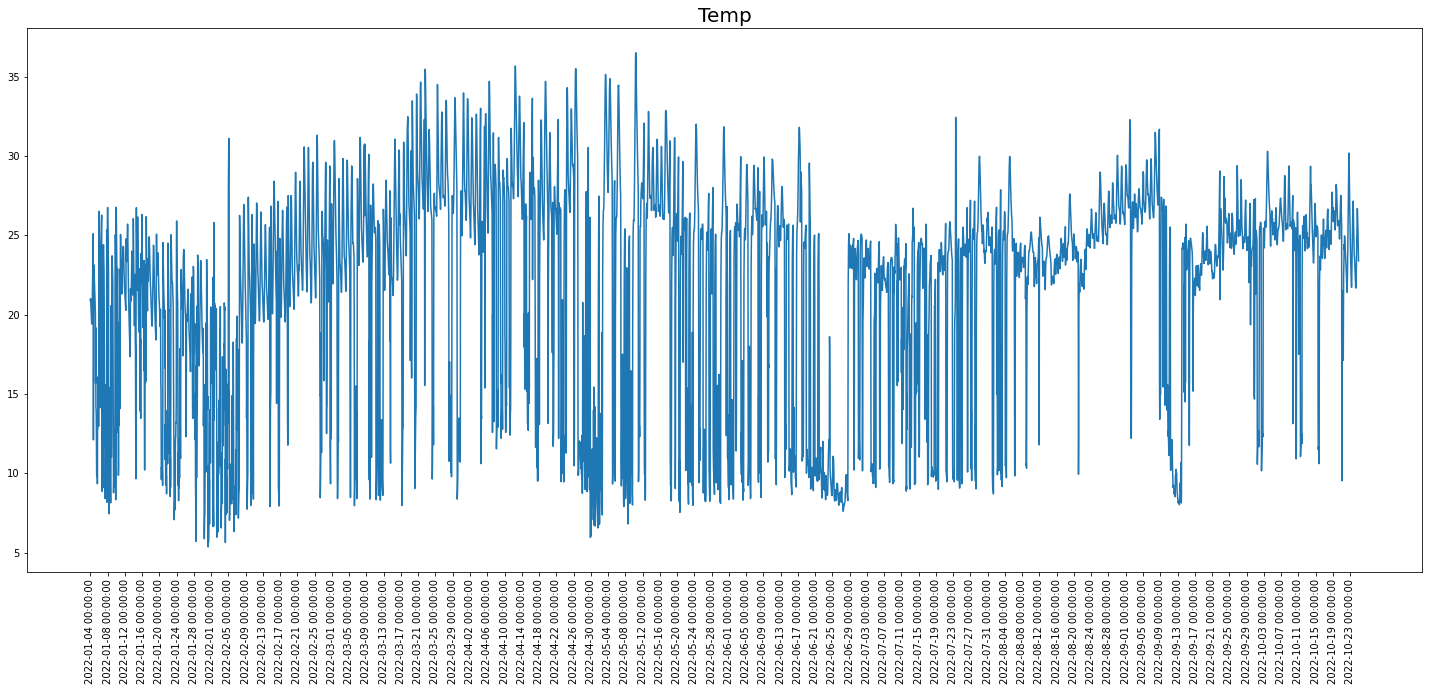

In [106]:
time = df4['Datetime'].values
temp  = df4['Hourly_Temp'].values
 
plt.figure(figsize=(25,10))
plt.plot(time, temp)
plt.xticks(np.arange(0, len(time)+1, 96),rotation=90)
plt.title('Temp',
          fontsize=20);

In [130]:
train_size = int((len(temp)*0.8))
test_size = len(temp)-train_size
print("total dataset", len(temp))
print("total data latih",train_size,f"persentase ukuran data training {train_size/len(temp)}")
print("total data validasi",test_size,f"persentase ukuran data testing {test_size/len(temp)}")

total dataset 7056
total data latih 5644 persentase ukuran data training 0.7998866213151927
total data validasi 1412 persentase ukuran data testing 0.20011337868480725


In [131]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [132]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<1.5 and logs.get('val_mae')<1.5):
      print("\nMAE model untuk data latih dan validasi sudah < 1.5!!")
      self.model.stop_training = True
callbacks = myCallback()

Callback untuk stop pelatihan model ketika sudah mencapai MAE < 1,5 baik untuk pelatihan dan validasi. 

Metrik MAE < 1,5 dipilih dengan cara menghitung skala data "Hourly_Temp" pada dataset dengan nilai minimum 5,35 dan maksimum 36,5. Dimana 5% dari skala data adalah (36,5-5,35)*0,05 = 1,5575

In [133]:
train_set = windowed_dataset(temp[:train_size], window_size=168, batch_size=196, shuffle_buffer=2000)
test_set = windowed_dataset(temp[train_size:], window_size=168, batch_size=196, shuffle_buffer=2000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(168, return_sequences=True),
  tf.keras.layers.LSTM(168),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
])

Dipilih window sebesar 168, karena data temperatur diambil setiap 1 jam, berarti 1 hari adalah 24 data. Karena window 168 maka, 1 window adalah 168/24 = 7 hari (1 minggu)

In [134]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
result = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/100
28/28 - 7s - loss: 20.6120 - mae: 21.1120 - val_loss: 22.5893 - val_mae: 23.0893 - 7s/epoch - 250ms/step
Epoch 2/100
28/28 - 3s - loss: 20.1769 - mae: 20.6769 - val_loss: 22.0518 - val_mae: 22.5518 - 3s/epoch - 92ms/step
Epoch 3/100
28/28 - 3s - loss: 19.5533 - mae: 20.0533 - val_loss: 21.2890 - val_mae: 21.7890 - 3s/epoch - 108ms/step
Epoch 4/100
28/28 - 2s - loss: 18.5436 - mae: 19.0436 - val_loss: 19.8583 - val_mae: 20.3583 - 2s/epoch - 85ms/step
Epoch 5/100
28/28 - 2s - loss: 16.3331 - mae: 16.8331 - val_loss: 16.3175 - val_mae: 16.8174 - 2s/epoch - 85ms/step
Epoch 6/100
28/28 - 2s - loss: 10.7515 - mae: 11.2429 - val_loss: 7.1438 - val_mae: 7.6412 - 2s/epoch - 84ms/step
Epoch 7/100
28/28 - 3s - loss: 5.1677 - mae: 5.6412 - val_loss: 2.9058 - val_mae: 3.3819 - 3s/epoch - 105ms/step
Epoch 8/100
28/28 - 2s - loss: 4.6250 - mae: 5.0931 - val_loss: 2.3594 - val_mae: 2.8112 - 2s/epoch - 84ms/step
Epoch 9/100
28/28 - 3s - loss: 4.4491 - mae: 4.9164 - val_loss: 2.2735 - val_ma

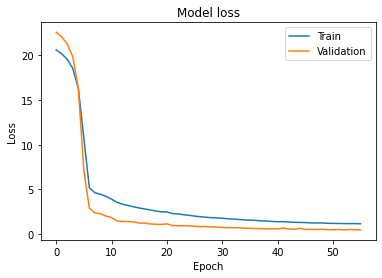

In [135]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

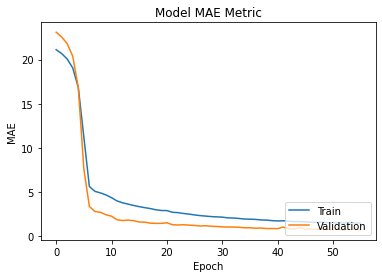

In [136]:
plt.plot(result.history['mae'])
plt.plot(result.history['val_mae'])
plt.title('Model MAE Metric')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()